In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzf food-101.tar.gz
!unzip src.zip
!pip install traker[fast] --quiet

--2024-06-24 15:50:16--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-06-24 15:50:17--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz.1’

food-101.tar.gz.1     0%[                    ]  38.48M  10.6MB/s    eta 7m 51s ^C
^C
Archive:  src.zip
replace src/class_metrics.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ERROR: Operation cancelled by user


In [ ]:
!unzip src.zip

Archive:  src.zip
   creating: src/
  inflating: src/class_metrics.py    
  inflating: src/dataset.py          
  inflating: src/early_stopping.py   
  inflating: src/model.py            
  inflating: src/plots.py            
  inflating: src/train.py            
  inflating: src/trak_utils.py       


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%load_ext autoreload
%autoreload 2

from transformers import AutoImageProcessor
import torchvision.transforms as transforms
import numpy as np
import torch
import os
import re
from trak import TRAKer
from tqdm import tqdm

from src.train import train_model, train_without_bottom_k_alignment_scoring_data, train_without_top_k_alignment_scoring_data, train_without_negative_alignment_scoring_data
from src.early_stopping import EarlyStopping
from src.dataset import get_dataset_split, get_dl_targets, get_chosen_classes
from src.model import get_model, compute_val_dataset_predictions, recall_for_class, calculate_model_loss_and_accuracy
from src.trak_utils import ResNetOutput, featurize_traker, get_traker_scores
from src.plots import plot_single_image, plot_extreme_two_trak_examples_for_image
from src.class_metrics import compute_class_weights, compute_class_alignment_scores, compute_class_weights_original_formula

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [2]:
args = {
    'lr': 1e-4,
    'batch_size': 64,
    'batch_size_reduced': 32,
    'num_epochs': 20,
    'epochs_per_checkpoint': 1,
    'dataset_path': "data/food-101/food-101/images",
    #'base_models_path': "/content/drive/MyDrive/trak_models_v2",
    'base_models_path': "trak_models_v2",
    'resnet_version': "microsoft/resnet-18",
    'train_split_rate': 0.8,
    'test_split_rate': 0.2,
    'patience': 3
}

seeds = [1, 123, 41, 534, 2]

In [3]:
processor = AutoImageProcessor.from_pretrained(args['resnet_version'])

def preprocess_image(image):
    image = transforms.functional.pil_to_tensor(image)
    processed_image = processor.preprocess(image)["pixel_values"][0]
    return torch.from_numpy(processed_image)

# classes:
# bruschetta, garlic bread, grilled salmon, omelette, pancakes,
# pizza, porkchop, spaghetti bolognese, spaghetti carbonara, steak

num_classes = 10
chosen_indices = [10, 46, 50, 67, 72, 76, 77, 90, 91, 93]

assert num_classes == len(chosen_indices)

chosen_classes = get_chosen_classes(args['dataset_path'], chosen_indices)

print("Chosen classes: " + str(chosen_classes))

if not os.path.exists(args['base_models_path']):
    os.makedirs(args['base_models_path'])

Chosen classes: ['bruschetta', 'garlic_bread', 'grilled_salmon', 'omelette', 'pancakes', 'pizza', 'pork_chop', 'spaghetti_bolognese', 'spaghetti_carbonara', 'steak']


In [ ]:
for seed in seeds:
  print("Run experiment for seed: {}".format(seed))

  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

  base_model_path = os.path.join(args['base_models_path'], "seed_" + str(seed))

  if not os.path.exists(base_model_path):
    os.makedirs(base_model_path)

  train_dataset, test_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], seed, preprocess_image)

  train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
  test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

  model = get_model(base_model_path, args['resnet_version'], num_classes)

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  early_stopping = EarlyStopping(patience=args['patience'], min_delta=0.001)

  model_finetuned_path = os.path.join(base_model_path, "model_finetuned_baseline.pth")

  train_model(model, train_dl, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping, epochs_per_checkpoint=args['epochs_per_checkpoint'], model_save_path=model_finetuned_path)

  torch.save(model.state_dict(), model_finetuned_path)

  ckpt_files = [f for f in os.listdir(base_model_path) if re.match(r'.*[0-9]\.pth', f)]
  ckpt_files.sort()
  ckpt_files = ckpt_files[:-args['patience']]

  print("Running Trak for checkpoints: " + str(ckpt_files))

  ckpts = [torch.load(os.path.join(base_model_path, ckpt), map_location=device) for ckpt in ckpt_files]

  train_dl_no_shuffle = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size_reduced'], shuffle=False)
  test_dl_no_shuffle = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size_reduced'], shuffle=False)
  model = model.to(device)

  !rm -rf trak_results

  traker = TRAKer(model=model,
                  task=ResNetOutput(),
                  train_set_size=len(train_dl_no_shuffle.dataset),
                  proj_dim=512,
                  proj_max_batch_size=8)

  exp_name = "test_val"

  test_scores = get_traker_scores(traker, exp_name, ckpts, train_dl_no_shuffle, test_dl_no_shuffle)
  test_scores_path = os.path.join(base_model_path, "test_scores.npy")

  np.save(test_scores_path, test_scores)


## Removing bottom 200 scoring examples

In [4]:
models = []

for i, seed in enumerate(seeds):
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    base_model_path = os.path.join(exp_path, "model_finetuned_baseline.pth")
    base_model = get_model(base_model_path, args['resnet_version'], num_classes).to(device)
    model_path = os.path.join(exp_path, "resnet-18_10classes_base.pth")
    model = get_model(model_path, args['resnet_version'], num_classes).to(device)
    trak_path = os.path.join(exp_path, "test_scores.npy")
    val_trak_scores = np.load(trak_path)
    train_dataset, val_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], seed, preprocess_image)
    train_without_bottom_k_alignment_scoring_data(base_model, model, train_dataset, val_dataset, 200, val_trak_scores, args["batch_size"], epochs=args["num_epochs"], lr=args["lr"])
    models.append(model)

100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


[Epoch 1] Loss: 0.870, Train Acc: 0.706,Valid loss: 0.617 Valid Acc: 0.788


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


[Epoch 2] Loss: 0.262, Train Acc: 0.925,Valid loss: 0.558 Valid Acc: 0.825


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


[Epoch 3] Loss: 0.075, Train Acc: 0.990,Valid loss: 0.566 Valid Acc: 0.821


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


[Epoch 4] Loss: 0.026, Train Acc: 0.998,Valid loss: 0.560 Valid Acc: 0.838


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


[Epoch 5] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.565 Valid Acc: 0.836
Early stopping at epoch 5


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


[Epoch 1] Loss: 0.840, Train Acc: 0.721,Valid loss: 0.584 Valid Acc: 0.807


100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


[Epoch 2] Loss: 0.247, Train Acc: 0.930,Valid loss: 0.560 Valid Acc: 0.817


100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


[Epoch 3] Loss: 0.066, Train Acc: 0.991,Valid loss: 0.549 Valid Acc: 0.827


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


[Epoch 4] Loss: 0.024, Train Acc: 0.998,Valid loss: 0.545 Valid Acc: 0.836


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.540 Valid Acc: 0.845


100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


[Epoch 6] Loss: 0.008, Train Acc: 0.999,Valid loss: 0.561 Valid Acc: 0.838


100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


[Epoch 7] Loss: 0.005, Train Acc: 1.000,Valid loss: 0.563 Valid Acc: 0.841


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


[Epoch 8] Loss: 0.004, Train Acc: 1.000,Valid loss: 0.568 Valid Acc: 0.842
Early stopping at epoch 8


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


[Epoch 1] Loss: 0.869, Train Acc: 0.713,Valid loss: 0.629 Valid Acc: 0.787


100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


[Epoch 2] Loss: 0.252, Train Acc: 0.932,Valid loss: 0.635 Valid Acc: 0.796


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


[Epoch 3] Loss: 0.070, Train Acc: 0.990,Valid loss: 0.628 Valid Acc: 0.809


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


[Epoch 4] Loss: 0.025, Train Acc: 0.998,Valid loss: 0.618 Valid Acc: 0.822


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


[Epoch 5] Loss: 0.012, Train Acc: 0.999,Valid loss: 0.602 Valid Acc: 0.823


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.611 Valid Acc: 0.826


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


[Epoch 7] Loss: 0.004, Train Acc: 1.000,Valid loss: 0.629 Valid Acc: 0.828


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


[Epoch 8] Loss: 0.007, Train Acc: 0.999,Valid loss: 0.702 Valid Acc: 0.810
Early stopping at epoch 8


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


[Epoch 1] Loss: 0.859, Train Acc: 0.715,Valid loss: 0.602 Valid Acc: 0.801


100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


[Epoch 2] Loss: 0.253, Train Acc: 0.932,Valid loss: 0.541 Valid Acc: 0.831


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


[Epoch 3] Loss: 0.074, Train Acc: 0.989,Valid loss: 0.551 Valid Acc: 0.822


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


[Epoch 4] Loss: 0.022, Train Acc: 0.999,Valid loss: 0.577 Valid Acc: 0.816


100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


[Epoch 5] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.557 Valid Acc: 0.831
Early stopping at epoch 5


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


[Epoch 1] Loss: 0.862, Train Acc: 0.715,Valid loss: 0.572 Valid Acc: 0.810


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


[Epoch 2] Loss: 0.254, Train Acc: 0.929,Valid loss: 0.527 Valid Acc: 0.827


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


[Epoch 3] Loss: 0.068, Train Acc: 0.991,Valid loss: 0.505 Valid Acc: 0.836


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


[Epoch 4] Loss: 0.023, Train Acc: 0.999,Valid loss: 0.516 Valid Acc: 0.847


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


[Epoch 5] Loss: 0.009, Train Acc: 1.000,Valid loss: 0.512 Valid Acc: 0.842


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


[Epoch 6] Loss: 0.006, Train Acc: 1.000,Valid loss: 0.529 Valid Acc: 0.841
Early stopping at epoch 6


In [6]:
for i, seed in enumerate(seeds):
    model = models[i]
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    torch.save(model.state_dict(), f"{exp_path}/without_bottom_200_examples.pth")

In [4]:
models = []

for i, seed in enumerate(seeds):
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    model = get_model(f"{exp_path}/without_bottom_200_examples.pth", args['resnet_version'], num_classes).to(device)
    models.append(model)

In [7]:
val_losses = []
val_accuracies = []

for i, seed in enumerate(seeds):
    model = models[i]
    _, val_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], seed, preprocess_image)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args["batch_size"], shuffle=False)
    loss, accuracy = calculate_model_loss_and_accuracy(model, val_dl)
    val_losses.append(loss)
    val_accuracies.append(accuracy)

100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

[0.5583262844011188, 0.539725000038743, 0.6020940961316228, 0.5410091569647193, 0.5048665385693312]
[0.8245, 0.8445, 0.823, 0.831, 0.836]


In [11]:
print([f"{np.mean(val_losses):.3f}", f"{np.std(val_losses):.3f}"])
print([f"{np.mean(val_accuracies):.3f}", f"{np.std(val_accuracies):.3f}"])

['0.549', '0.032']
['0.832', '0.008']


## Surprising / insightful examples (model 1)

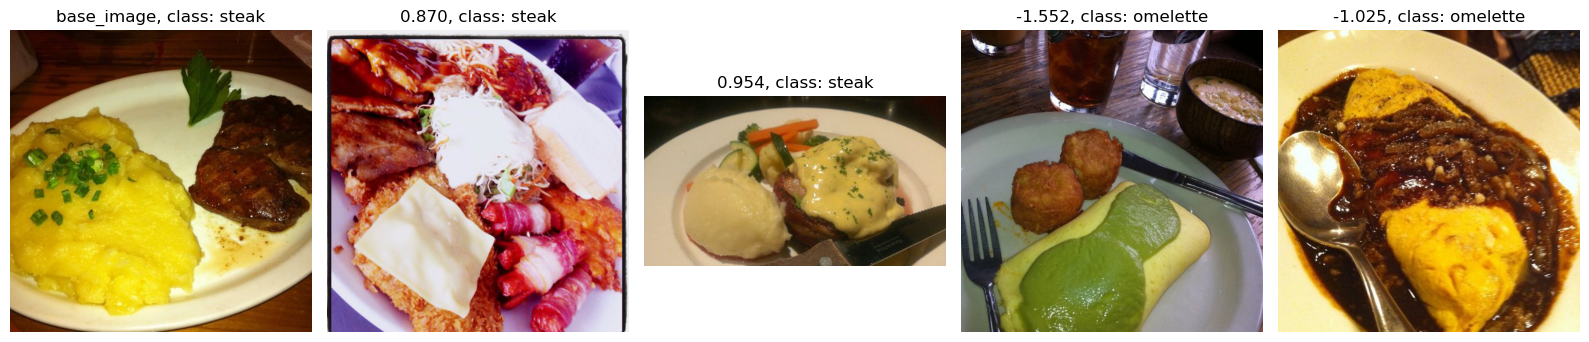

In [5]:
first_model = models[0]
first_model_seed = seeds[0]
first_model_trak_scores = np.load(f"trak_models_v2/seed_{first_model_seed}/test_scores.npy")

train_dataset_no_transform, test_dataset_no_transform = get_dataset_split(
    args['dataset_path'],
    chosen_indices,
    args['train_split_rate'],
    args['test_split_rate'],
    first_model_seed,
    transforms.ToTensor()
)

image_id = 0

plot_extreme_two_trak_examples_for_image(first_model_trak_scores, train_dataset_no_transform, test_dataset_no_transform, image_id, chosen_classes)

In [6]:
train_dataset, val_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], first_model_seed, preprocess_image)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args["batch_size"], shuffle=False)
val_targets = get_dl_targets(val_dl)
val_preds = compute_val_dataset_predictions(first_model, val_dl)
num_classes = len(train_dataset.dataset.classes)
class_weights = compute_class_weights(val_preds, val_targets, num_classes)

group_alignment_scores = compute_class_alignment_scores(first_model_trak_scores, val_targets, class_weights, num_classes)

100%|██████████| 8000/8000 [00:01<00:00, 7170.49it/s]


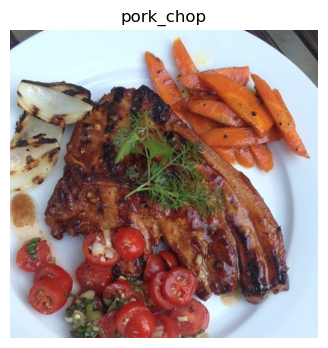

In [7]:
# let's examine the image (and its class), where the alignment score is the highest

top_alignment_image_id = np.argmax(group_alignment_scores)
top_alignment_image = train_dataset_no_transform[top_alignment_image_id][0]
top_alignment_image_class = train_dataset_no_transform[top_alignment_image_id][1]

plot_single_image(top_alignment_image, chosen_classes[top_alignment_image_class])

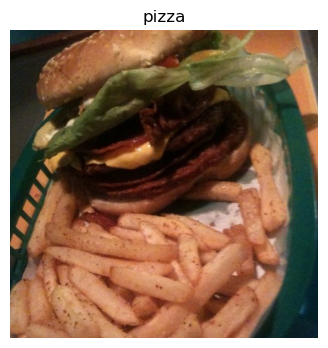

In [8]:
# let's examine the image with lowest score

bottom_alignment_image_id = np.argmin(group_alignment_scores)
bottom_alignment_image = train_dataset_no_transform[bottom_alignment_image_id][0]
bottom_alignment_image_class = train_dataset_no_transform[bottom_alignment_image_id][1]

plot_single_image(bottom_alignment_image, chosen_classes[bottom_alignment_image_class])

## Opposite experiment - removing most positively impactful examples

In [10]:
models = []

for i, seed in enumerate(seeds):
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    base_model_path = os.path.join(exp_path, "model_finetuned_baseline.pth")
    base_model = get_model(base_model_path, args['resnet_version'], num_classes).to(device)
    model_path = os.path.join(exp_path, "resnet-18_10classes_base.pth")
    model = get_model(model_path, args['resnet_version'], num_classes).to(device)
    trak_path = os.path.join(exp_path, "test_scores.npy")
    val_trak_scores = np.load(trak_path)
    train_dataset, val_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], seed, preprocess_image)
    train_without_top_k_alignment_scoring_data(base_model, model, train_dataset, val_dataset, 200, val_trak_scores, args["batch_size"], epochs=args["num_epochs"], lr=args["lr"])
    models.append(model)

100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


[Epoch 1] Loss: 0.892, Train Acc: 0.708,Valid loss: 0.624 Valid Acc: 0.792


100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


[Epoch 2] Loss: 0.271, Train Acc: 0.926,Valid loss: 0.533 Valid Acc: 0.828


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


[Epoch 3] Loss: 0.070, Train Acc: 0.992,Valid loss: 0.539 Valid Acc: 0.828


100%|██████████| 32/32 [00:49<00:00,  1.54s/it]


[Epoch 4] Loss: 0.023, Train Acc: 0.999,Valid loss: 0.597 Valid Acc: 0.818


100%|██████████| 32/32 [00:51<00:00,  1.61s/it]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.554 Valid Acc: 0.832
Early stopping at epoch 5


100%|██████████| 32/32 [00:48<00:00,  1.52s/it]


[Epoch 1] Loss: 0.887, Train Acc: 0.715,Valid loss: 0.593 Valid Acc: 0.801


100%|██████████| 32/32 [00:45<00:00,  1.41s/it]


[Epoch 2] Loss: 0.273, Train Acc: 0.925,Valid loss: 0.546 Valid Acc: 0.823


100%|██████████| 32/32 [00:44<00:00,  1.40s/it]


[Epoch 3] Loss: 0.079, Train Acc: 0.987,Valid loss: 0.553 Valid Acc: 0.831


100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


[Epoch 4] Loss: 0.027, Train Acc: 0.998,Valid loss: 0.551 Valid Acc: 0.830


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.552 Valid Acc: 0.840
Early stopping at epoch 5


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


[Epoch 1] Loss: 0.886, Train Acc: 0.708,Valid loss: 0.631 Valid Acc: 0.790


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


[Epoch 2] Loss: 0.269, Train Acc: 0.929,Valid loss: 0.601 Valid Acc: 0.807


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


[Epoch 3] Loss: 0.073, Train Acc: 0.989,Valid loss: 0.590 Valid Acc: 0.821


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


[Epoch 4] Loss: 0.023, Train Acc: 0.999,Valid loss: 0.601 Valid Acc: 0.816


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


[Epoch 5] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.616 Valid Acc: 0.828


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.624 Valid Acc: 0.826
Early stopping at epoch 6


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


[Epoch 1] Loss: 0.881, Train Acc: 0.716,Valid loss: 0.686 Valid Acc: 0.765


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


[Epoch 2] Loss: 0.270, Train Acc: 0.926,Valid loss: 0.583 Valid Acc: 0.796


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


[Epoch 3] Loss: 0.073, Train Acc: 0.991,Valid loss: 0.565 Valid Acc: 0.811


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


[Epoch 4] Loss: 0.025, Train Acc: 0.999,Valid loss: 0.575 Valid Acc: 0.825


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


[Epoch 5] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.577 Valid Acc: 0.819


100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.586 Valid Acc: 0.827
Early stopping at epoch 6


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


[Epoch 1] Loss: 0.885, Train Acc: 0.713,Valid loss: 0.611 Valid Acc: 0.804


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


[Epoch 2] Loss: 0.270, Train Acc: 0.927,Valid loss: 0.544 Valid Acc: 0.820


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


[Epoch 3] Loss: 0.077, Train Acc: 0.989,Valid loss: 0.524 Valid Acc: 0.838


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


[Epoch 4] Loss: 0.022, Train Acc: 0.999,Valid loss: 0.527 Valid Acc: 0.839


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


[Epoch 5] Loss: 0.010, Train Acc: 1.000,Valid loss: 0.546 Valid Acc: 0.840


100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.544 Valid Acc: 0.844
Early stopping at epoch 6


In [11]:
for i, seed in enumerate(seeds):
    model = models[i]
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    torch.save(model.state_dict(), f"{exp_path}/without_top_200_examples.pth")

In [12]:
models = []

for i, seed in enumerate(seeds):
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    model = get_model(f"{exp_path}/without_top_200_examples.pth", args['resnet_version'], num_classes).to(device)
    models.append(model)

In [13]:
val_losses = []
val_accuracies = []

for i, seed in enumerate(seeds):
    model = models[i]
    _, val_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], seed, preprocess_image)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args["batch_size"], shuffle=False)
    loss, accuracy = calculate_model_loss_and_accuracy(model, val_dl)
    val_losses.append(loss)
    val_accuracies.append(accuracy)

print([f"{np.mean(val_losses):.3f}", f"{np.std(val_losses):.3f}"])
print([f"{np.mean(val_accuracies):.3f}", f"{np.std(val_accuracies):.3f}"])

100%|██████████| 32/32 [00:19<00:00,  1.61it/s]

['0.552', '0.024']
['0.824', '0.009']


## Original heuristic - removing all examples with negative alignment score

In [14]:
models = []

for i, seed in enumerate(seeds):
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    base_model_path = os.path.join(exp_path, "model_finetuned_baseline.pth")
    base_model = get_model(base_model_path, args['resnet_version'], num_classes).to(device)
    model_path = os.path.join(exp_path, "resnet-18_10classes_base.pth")
    model = get_model(model_path, args['resnet_version'], num_classes).to(device)
    trak_path = os.path.join(exp_path, "test_scores.npy")
    val_trak_scores = np.load(trak_path)
    train_dataset, val_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], seed, preprocess_image)
    train_without_negative_alignment_scoring_data(base_model, model, train_dataset, val_dataset, 200, val_trak_scores, args["batch_size"], epochs=args["num_epochs"], lr=args["lr"])
    models.append(model)

100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


[Epoch 1] Loss: 0.866, Train Acc: 0.715,Valid loss: 0.625 Valid Acc: 0.783


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


[Epoch 2] Loss: 0.246, Train Acc: 0.931,Valid loss: 0.572 Valid Acc: 0.814


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


[Epoch 3] Loss: 0.075, Train Acc: 0.989,Valid loss: 0.551 Valid Acc: 0.835


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


[Epoch 4] Loss: 0.025, Train Acc: 0.998,Valid loss: 0.557 Valid Acc: 0.837


100%|██████████| 32/32 [00:19<00:00,  1.60it/s]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.566 Valid Acc: 0.834


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.579 Valid Acc: 0.837
Early stopping at epoch 6


100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


[Epoch 1] Loss: 0.837, Train Acc: 0.732,Valid loss: 0.608 Valid Acc: 0.794


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


[Epoch 2] Loss: 0.226, Train Acc: 0.937,Valid loss: 0.592 Valid Acc: 0.805


100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


[Epoch 3] Loss: 0.056, Train Acc: 0.995,Valid loss: 0.577 Valid Acc: 0.816


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


[Epoch 4] Loss: 0.020, Train Acc: 1.000,Valid loss: 0.598 Valid Acc: 0.822


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


[Epoch 5] Loss: 0.013, Train Acc: 0.999,Valid loss: 0.590 Valid Acc: 0.835


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


[Epoch 6] Loss: 0.006, Train Acc: 1.000,Valid loss: 0.590 Valid Acc: 0.837
Early stopping at epoch 6


100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


[Epoch 1] Loss: 0.856, Train Acc: 0.721,Valid loss: 0.613 Valid Acc: 0.792


100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


[Epoch 2] Loss: 0.244, Train Acc: 0.930,Valid loss: 0.612 Valid Acc: 0.798


100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


[Epoch 3] Loss: 0.066, Train Acc: 0.992,Valid loss: 0.598 Valid Acc: 0.818


100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


[Epoch 4] Loss: 0.022, Train Acc: 1.000,Valid loss: 0.579 Valid Acc: 0.831


100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.618 Valid Acc: 0.828


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.618 Valid Acc: 0.826


100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


[Epoch 7] Loss: 0.005, Train Acc: 1.000,Valid loss: 0.630 Valid Acc: 0.827
Early stopping at epoch 7


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


[Epoch 1] Loss: 0.864, Train Acc: 0.718,Valid loss: 0.631 Valid Acc: 0.796


100%|██████████| 32/32 [00:44<00:00,  1.41s/it]


[Epoch 2] Loss: 0.260, Train Acc: 0.928,Valid loss: 0.567 Valid Acc: 0.814


100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


[Epoch 3] Loss: 0.090, Train Acc: 0.986,Valid loss: 0.562 Valid Acc: 0.822


100%|██████████| 32/32 [00:52<00:00,  1.65s/it]


[Epoch 4] Loss: 0.037, Train Acc: 0.996,Valid loss: 0.554 Valid Acc: 0.826


100%|██████████| 32/32 [00:48<00:00,  1.52s/it]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.560 Valid Acc: 0.837


100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


[Epoch 6] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.574 Valid Acc: 0.833


100%|██████████| 32/32 [00:55<00:00,  1.74s/it]


[Epoch 7] Loss: 0.035, Train Acc: 0.995,Valid loss: 0.609 Valid Acc: 0.815
Early stopping at epoch 7


100%|██████████| 32/32 [00:54<00:00,  1.71s/it]


[Epoch 1] Loss: 0.847, Train Acc: 0.721,Valid loss: 0.603 Valid Acc: 0.802


100%|██████████| 32/32 [00:54<00:00,  1.69s/it]


[Epoch 2] Loss: 0.234, Train Acc: 0.937,Valid loss: 0.547 Valid Acc: 0.823


100%|██████████| 32/32 [00:52<00:00,  1.66s/it]


[Epoch 3] Loss: 0.063, Train Acc: 0.992,Valid loss: 0.540 Valid Acc: 0.833


100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


[Epoch 4] Loss: 0.019, Train Acc: 0.999,Valid loss: 0.535 Valid Acc: 0.841


100%|██████████| 32/32 [00:54<00:00,  1.71s/it]


[Epoch 5] Loss: 0.009, Train Acc: 1.000,Valid loss: 0.533 Valid Acc: 0.840


100%|██████████| 32/32 [00:56<00:00,  1.77s/it]


[Epoch 6] Loss: 0.006, Train Acc: 1.000,Valid loss: 0.538 Valid Acc: 0.842


100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


[Epoch 7] Loss: 0.004, Train Acc: 1.000,Valid loss: 0.540 Valid Acc: 0.850


100%|██████████| 32/32 [00:55<00:00,  1.74s/it]

[Epoch 8] Loss: 0.003, Train Acc: 1.000,Valid loss: 0.548 Valid Acc: 0.845
Early stopping at epoch 8


In [15]:
for i, seed in enumerate(seeds):
    model = models[i]
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    torch.save(model.state_dict(), f"{exp_path}/without_negative_examples.pth")

In [16]:
models = []

for i, seed in enumerate(seeds):
    exp_path = os.path.join("trak_models_v2", f"seed_{seed}")
    model = get_model(f"{exp_path}/without_negative_examples.pth", args['resnet_version'], num_classes).to(device)
    models.append(model)

In [17]:
val_losses = []
val_accuracies = []

for i, seed in enumerate(seeds):
    model = models[i]
    _, val_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], seed, preprocess_image)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args["batch_size"], shuffle=False)
    loss, accuracy = calculate_model_loss_and_accuracy(model, val_dl)
    val_losses.append(loss)
    val_accuracies.append(accuracy)

print([f"{np.mean(val_losses):.3f}", f"{np.std(val_losses):.3f}"])
print([f"{np.mean(val_accuracies):.3f}", f"{np.std(val_accuracies):.3f}"])

100%|██████████| 32/32 [00:23<00:00,  1.35it/s]

['0.559', '0.017']
['0.829', '0.008']


## Shortcut learning / simplicity bias

In [ ]:
#